In [ ]:
#!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import matplotlib.pyplot as plt

In [20]:

df1 = yf.download('ADANIGREEN.NS', start="2024-05-22", end="2025-05-22")
df2 = yf.download('BEL.NS', start="2024-05-22", end="2025-05-22")
# Flatten the columns if they are MultiIndex
if isinstance(df1.columns, pd.MultiIndex):
    df1.columns = df1.columns.get_level_values(0)
if isinstance(df2.columns, pd.MultiIndex):
    df2.columns = df2.columns.get_level_values(0)
df1=df1.reset_index()
df2=df2.reset_index()
print(type(df1['Close']))
print(type(df2['Close']))
print(df1.columns)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [4]:
#basic EMA crossover
def strategy1(df, price_col):
  signal= pd.Series(0, index=df.index)
  signal.iloc[0]=0
  ema= df[price_col].ewm(span=14, adjust=False).mean()
  for i in range(1,len(df)):
    if df[price_col].iloc[i-1] < ema.iloc[i-1] and df[price_col].iloc[i] > ema.iloc[i]:
      signal.iloc[i]=1
    elif df[price_col].iloc[i-1] > ema.iloc[i-1] and df[price_col].iloc[i] < ema.iloc[i]:
      signal.iloc[i]=-1
    else:
      signal.iloc[i]=0
  return signal



In [5]:
#EMA strategy with dynamic ATR band
def strategy2(df, price_col_open, price_col_close):
  signal= pd.Series(0, index=df.index)
  signal.iloc[0]=0
  ema= df[price_col_close].ewm(span=14, adjust=False).mean()
  open= df[price_col_open]
  close= df[price_col_close]
  for i in range(1,len(df)):
    atr_band= close.iloc[i]-open.iloc[i]
    buy_band= ema.iloc[i]+atr_band
    sell_band= ema.iloc[i]-atr_band
    if close.iloc[i]>buy_band:
      signal.iloc[i]=1
    elif close.iloc[i]<sell_band:
      signal.iloc[i]=-1
    else:
      signal.iloc[i]=0
  return signal

In [89]:
#ATR breakout strategy
def strategy3(df,price_col_open, price_col_high, price_col_low, price_col_close,k):
  signal= pd.Series(0, index=df.index)
  signal.iloc[0]=0
  open= df[price_col_open]
  close= df[price_col_close]
  high= df[price_col_high]
  low= df[price_col_low]
  ema= close.ewm(span=14, adjust=False).mean()
  TR= pd.Series(0, index=df.index)

  prev_close = close.shift(1)
  tr1 = high - low
  tr2 = (high - prev_close).abs()
  tr3 = (low - prev_close).abs()
  TR = pd.concat([tr1, tr2, tr3], axis=1)
  TR.columns = ['tr1', 'tr2', 'tr3']
  TR = TR.max(axis=1)
  TR = TR.fillna(0)
  atr= TR.ewm(span=14, adjust=False).mean()
  for i in range(1,len(df)):
    if pd.isna(ema.iloc[i]) or pd.isna(atr.iloc[i]):
      signal.iloc[i] = 0
      continue
    buy_band= ema.iloc[i] + k*atr.iloc[i]
    sell_band= ema.iloc[i] - k*atr.iloc[i]
    if close.iloc[i]>buy_band:
      signal.iloc[i]=1
    elif close.iloc[i]<sell_band:
      signal.iloc[i]=-1
    else:
      signal.iloc[i]=0
  return signal

In [90]:
initial_investment= 100000
risk_free_rate= 0
risk_free_profit= risk_free_rate*initial_investment #time=1year
# daily_df to keep log of everyday happenings
daily_df1= pd.DataFrame(index= df1.index, columns=['portfolio_value','stock_qty','profit%'])
daily_df1.iloc[0] = [initial_investment, 0, (initial_investment / initial_investment - 1) * 100]

daily_df2= pd.DataFrame(index= df2.index, columns=['portfolio_value','stock_qty','profit%'])
daily_df2.iloc[0] = [initial_investment, 0, (initial_investment / initial_investment - 1) * 100]




In [120]:
def backtest(df,price_col_open, price_col_high, price_col_low, price_col_close, signal, daily_df):

  current_qty=0
  current_pos=0
  portfolio= initial_investment
  trades=[]

  entry_price=None
  exit_price= None
  entry_idx=None
  exit_idx= None
  # pnl only when position squared off
  for i in range(1,len(df)):
    if signal.iloc[i]==1 and current_pos==0:

      current_qty= int(portfolio/df[price_col_close].iloc[i])
      portfolio-= current_qty*df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      entry_price= df[price_col_close].iloc[i]
      entry_idx=i

      current_pos=1

    elif signal.iloc[i]==-1 and current_pos==0: #0 means no position, 0 in signal means hold

      current_qty= int(portfolio/df[price_col_close].iloc[i])
      portfolio+= current_qty*df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      entry_price= df[price_col_close].iloc[i]
      entry_idx=i

      current_pos=-1

    # squaring off
    elif signal.iloc[i]==-1 and current_pos==1:

      portfolio+= int(current_qty*df[price_col_close].iloc[i])
      exit_price= df[price_col_close].iloc[i]
      exit_idx= i

      daily_df.loc[i,'stock_qty']= 0
      daily_df.loc[i,'portfolio_value']= portfolio


      pnl= current_qty*(exit_price- entry_price)
      trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'long',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

      current_qty=0
      current_pos=0
      entry_idx, exit_idx=None, None
      exit_price, entry_price= None, None

    elif signal.iloc[i]==1 and current_pos==-1:

      portfolio-= int(current_qty*df[price_col_close].iloc[i])
      exit_idx=i
      exit_price= df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= 0
      daily_df.loc[i,'portfolio_value']= portfolio

      pnl= current_qty * (entry_price- exit_price)
      trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'short',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

      current_qty=0
      current_pos=0
      entry_idx, exit_idx=None, None
      exit_price, entry_price= None, None

    elif signal.iloc[i]==0 and current_pos==1:
      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio




  # last position square off
  if current_pos==1:

    portfolio+= current_qty*df[price_col_close].iloc[-1]
    exit_idx= len(df)-1
    exit_price= df[price_col_close].iloc[-1]

    daily_df.loc[i,'stock_qty']= 0
    daily_df.loc[i,'portfolio_value']= portfolio

    pnl= current_qty*(exit_price- entry_price)
    trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'long',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})


  elif current_pos==-1:

    portfolio-= current_qty*df[price_col_close].iloc[-1]
    exit_idx= len(df)-1
    exit_price= df[price_col_close].iloc[-1]

    daily_df.loc[i,'stock_qty']= 0
    daily_df.loc[i,'portfolio_value']= portfolio

    pnl= current_qty * (entry_price- exit_price)
    trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'short',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

  trades= pd.DataFrame(trades)

  return trades




In [ ]:
# benchmark return%, max drawdown for a trade and max, average drawdown% for portfolio , max dip for trade and avg, max dip% for portfolio

In [118]:
def metrics(df, trades):

  metric={}
  for i in range(1,len(trades)-1):
    minima= df['Close'].iloc[trades['exit_idx'].iloc[i-1]]
    peak= df['Close'].iloc[trades['exit_idx'].iloc[i-1]]
    max_drawdown=0
    drawdown_pct=0

    for j in range(trades['exit_idx'].iloc[i-1] +1, trades['entry_idx'].iloc[i+1] +1):
      if j< len(trades):
        if df['Close'].iloc[j]<minima:
          minima= df['Close'].iloc[j]
    trades['max_dip'].iloc[i]= (df['Close'].iloc[trades['entry_idx'].iloc[i]] - minima)/df['Close'].iloc[trades['entry_idx'].iloc[i]] *100

    for j in range(trades['exit_idx'].iloc[i-1] +1, trades['entry_idx'].iloc[i+1] +1):
      if j<len(trades):
        if df['Close'].iloc[j]>peak:
          peak= df['Close'].iloc[j]
          drawdown_pct = (peak - df['Close'].iloc[j]) * 100 / peak
        if drawdown_pct > max_drawdown:
          max_drawdown = drawdown_pct

    trades['max_drawdown'].iloc[i]= max_drawdown

  benchmark_return= (trades['pnl'].sum()-risk_free_profit)/initial_investment*100
  metric['Benchmark Return']= benchmark_return

  net_profit_pct= (trades['pnl'].sum())/initial_investment *100
  metric['Net Profit %']= net_profit_pct

  gross_profit_pct= (trades['pnl'][trades['pnl']>0].sum())/initial_investment *100
  metric['Gross Profit %']= gross_profit_pct

  metric['Total Trades']= len(trades)
  metric['Wins']= len(trades[trades['pnl']>0])
  metric['Losses']= len(trades[trades['pnl']<0])
  metric['Win Rate']= len(trades[trades['pnl']>0])/len(trades)*100
  metric['Avg Trade Duration']= trades['trade_duration'].mean()
  metric['Max Trade Duration']= trades['trade_duration'].max()
  metric['Max Drawdown']= trades['max_drawdown'].max()
  metric['Avg Drawdown']= trades['max_drawdown'].mean()
  metric['Max Dip']= trades['max_dip'].max()
  metric['Avg Dip']= trades['max_dip'].mean()

  if trades['pnl'].std()>0:
    metric['Sharpe Ratio']= (trades['pnl'].sum()-risk_free_profit)/trades['pnl'].std()
  else:
    metric['Sharpe Ratio']= np.nan

  if trades[trades['pnl']<0]['pnl'].std()>0:
    metric['Sortino Ratio']= (trades['pnl'].sum()-risk_free_profit)/trades[trades['pnl']<0]['pnl'].std()
  else:
    metric['Sortino Ratio']= np.nan

  return metric





In [35]:
from google.colab import files
uploaded = files.upload()
vix_data = pd.read_csv('hist_india_vix.csv')
vix_data.columns = vix_data.columns.str.strip()
vix_data['Date'] = pd.to_datetime(vix_data['Date'], format='%d-%b-%Y')



Saving hist_india_vix.csv to hist_india_vix.csv


In [36]:
vix_mean= vix_data['% Change'].mean() #mean and standard deviation of and on which period?
vix_std= vix_data['% Change'].std()

In [119]:
def modified_backtest(df,price_col_open, price_col_high, price_col_low, price_col_close, signal, daily_df, vix_mean, vix_std):

  current_qty=0
  current_pos=0
  portfolio= initial_investment
  trades=[]

  entry_price=None
  exit_price= None
  entry_idx=None
  exit_idx=None

  for i in range(1,len(df)):

    thresh1= vix_mean+ 0.5*vix_std
    thresh2= vix_mean+ 1.5*vix_std

    if signal.iloc[i]==1 and current_pos==0:
      if vix_data['% Change'].iloc[i]<thresh1:
        current_qty= int(portfolio/df[price_col_close].iloc[i])

      elif vix_data['% Change'].iloc[i]>=thresh1 and vix_data['% Change'].iloc[i]<thresh2:
        current_qty= int(portfolio/df[price_col_close].iloc[i] *0.75)

      elif vix_data['% Change'].iloc[i]>=thresh2:
        current_qty= int(portfolio/df[price_col_close].iloc[i] *0.5)


      portfolio-= current_qty*df[price_col_close].iloc[i]
      entry_idx=i
      entry_price= df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      current_pos=1

    elif signal.iloc[i]==-1 and current_pos==0: #0 means no position, 0 in signal means hold

      if vix_data['% Change'].iloc[i]<thresh1:
        current_qty= int(portfolio/df[price_col_close].iloc[i])

      elif vix_data['% Change'].iloc[i]>=thresh1 and vix_data['% Change'].iloc[i]<thresh2:
        current_qty= int(portfolio/df[price_col_close].iloc[i] *0.75)

      elif vix_data['% Change'].iloc[i]>=thresh2:
        current_qty= int(portfolio/df[price_col_close].iloc[i] *0.5)

      portfolio+= current_qty*df[price_col_close].iloc[i]
      entry_idx=i
      entry_price= df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

      current_pos=-1

    #squaring off # pnl only when position squared off
    elif signal.iloc[i]==-1 and current_pos==1:

      portfolio+= int(current_qty*df[price_col_close].iloc[i])
      exit_idx=i
      exit_price= df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= 0
      daily_df.loc[i,'portfolio_value']= portfolio

      pnl= current_qty *(exit_price- entry_price)
      trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'long',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

      exit_price, entry_price= None, None
      exit_idx, entry_idx= None, None
      current_qty=0
      current_pos=0

    elif signal.iloc[i]==1 and current_pos==-1:

      portfolio-= int(current_qty*df[price_col_close].iloc[i])
      exit_idx=i
      exit_price= df[price_col_close].iloc[i]

      daily_df.loc[i,'stock_qty']= 0
      daily_df.loc[i,'portfolio_value']= portfolio

      pnl= current_qty * (entry_price- exit_price)
      trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'short',
                     'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

      exit_price, entry_price= None, None
      exit_idx, entry_idx= None, None
      current_qty=0
      current_pos=0

    #holding
    elif signal.iloc[i]==0 and current_pos==1:

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio

    elif signal.iloc[i]==0 and current_pos==-1:

      daily_df.loc[i,'stock_qty']= current_qty
      daily_df.loc[i,'portfolio_value']= portfolio


  # last position square off
  if current_pos==1:
    portfolio+= current_qty*df[price_col_close].iloc[-1]
    exit_idx= len(df)-1
    exit_price= df[price_col_close].iloc[-1]

    daily_df.loc[i,'stock_qty']= 0
    daily_df.loc[i,'portfolio_value']= portfolio

    pnl= current_qty*(exit_price- entry_price)
    trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'long',
                   'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})


  elif current_pos==-1:
    portfolio-= current_qty*df[price_col_close].iloc[-1]
    exit_idx= len(df)-1
    exit_price= df[price_col_close].iloc[-1]

    daily_df.loc[i,'stock_qty']= 0
    daily_df.loc[i,'portfolio_value']= portfolio

    pnl= current_qty * (entry_price- exit_price)
    trades.append({'entry_idx':entry_idx, 'exit_idx':exit_idx, 'pnl':pnl, 'stock_qty':current_qty, 'trade':'short',
                   'trade_duration':exit_idx-entry_idx, 'entry_date':df['Date'].iloc[entry_idx], 'exit_date':df['Date'].iloc[exit_idx],
                     'trade return pct':pnl/initial_investment*100})

  trades= pd.DataFrame(trades)

  return trades



In [123]:
k=1.5
signal_adani= strategy3(df1, 'Open', 'High', 'Low', 'Close', k)
signal_bel= strategy3(df2, 'Open', 'High', 'Low','Close', k)

trades_adani= backtest(df1, 'Open', 'High', 'Low', 'Close', signal_adani, daily_df1)
trades_bel= backtest(df2, 'Open', 'High', 'Low', 'Close', signal_bel, daily_df2)

trades_adani.dropna(inplace=True)
trades_bel.dropna(inplace=True)

max_drawdown=pd.Series(0, index= df1.index)
max_dip=pd.Series(0, index= df1.index)

trades_adani['max_drawdown']= max_drawdown
trades_adani['max_dip']= max_dip
trades_bel['max_drawdown']= max_drawdown
trades_bel['max_dip']= max_dip

df1['signal']= signal_adani
df2['signal']= signal_bel
metrics_adani= metrics(df1, trades_adani)
metrics_bel= metrics(df2, trades_bel)


In [99]:
daily_df1['profit%']= (daily_df1['portfolio_value']/initial_investment-1)*100
daily_df2['profit%']= (daily_df2['portfolio_value']/initial_investment-1)*100
returns1= daily_df1['profit%'].dropna()
returns2= daily_df2['profit%'].dropna()

In [100]:
def risk_metrics(alpha, returns): #alpha- confidence percentage
  var= -np.percentile(returns, 100*(1-alpha))
  cvar= returns[returns<=-var].mean()
  return var, cvar

var1, cvar1= risk_metrics(0.95, returns1)
var2, cvar2= risk_metrics(0.95, returns2)
print(f'adani VaR:{var1}, adani CVaR:{cvar1}')
print(f'bel VaR:{var2}, bel CVaR:{cvar2}')

adani VaR:99.81470275878907, adani CVaR:-99.81598106260567
bel VaR:99.97371697998047, bel CVaR:-99.9737169799805


In [124]:
modified_daily_df1= pd.DataFrame(index= df1.index, columns=['portfolio_value','stock_qty','profit%'])
modified_daily_df1.iloc[0] = [initial_investment, 0, (initial_investment / initial_investment - 1) * 100]

modified_daily_df2= pd.DataFrame(index= df2.index, columns=['portfolio_value','stock_qty','profit%'])
modified_daily_df2.iloc[0] = [initial_investment, 0, (initial_investment / initial_investment - 1) * 100]

In [125]:
trades_modified_adani= modified_backtest(df1, 'Open', 'High', 'Low', 'Close', signal_adani, modified_daily_df1, vix_mean, vix_std)
trades_modified_bel= modified_backtest(df2, 'Open', 'High', 'Low', 'Close', signal_bel, modified_daily_df2, vix_mean, vix_std)

trades_modified_adani.dropna(inplace=True)
trades_modified_bel.dropna(inplace=True)

modified_max_drawdown=pd.Series(0, index= df1.index)
modified_max_dip=pd.Series(0, index= df1.index)
trades_modified_adani['max_drawdown']= modified_max_drawdown
trades_modified_adani['max_dip']= modified_max_dip
trades_modified_bel['max_drawdown']= modified_max_drawdown
trades_modified_bel['max_dip']= modified_max_dip

metrics_modified_adani= metrics(df1, trades_modified_adani)
metrics_modified_bel= metrics(df2, trades_modified_bel)

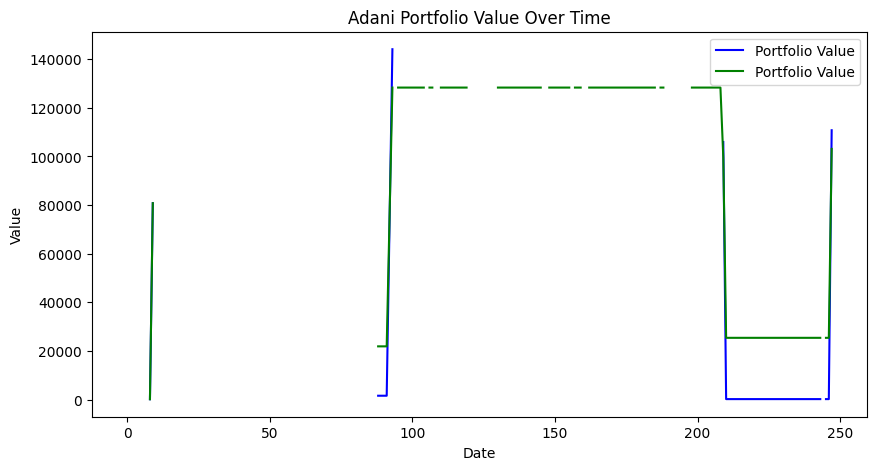

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(daily_df1['portfolio_value'], label='Portfolio Value', color='blue')
plt.plot(modified_daily_df1['portfolio_value'], label='Portfolio Value', color='green')
plt.title('Adani Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

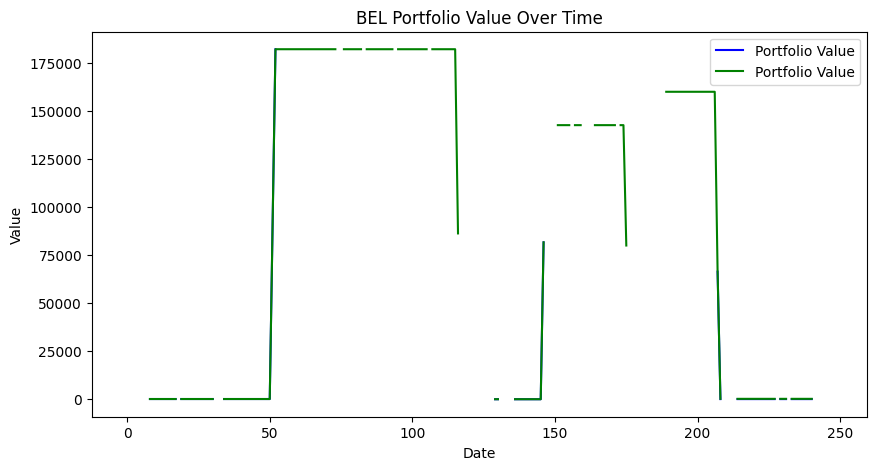

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(daily_df2['portfolio_value'], label='Portfolio Value', color='blue')
plt.plot(modified_daily_df2['portfolio_value'], label='Portfolio Value', color='green')
plt.title('BEL Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [126]:
adani_metrics_df = pd.DataFrame({
    'adani Metric': metrics_adani.keys(),
    'adani Fixed allocation metrics': metrics_adani.values(),
    'adani Dynamic asset allocation metrics': metrics_modified_adani.values()
})
bel_metrics_df = pd.DataFrame({
    'bel Metric': metrics_bel.keys(),
    'bel Fixed allocation metrics': metrics_bel.values(),
    'bel Dynamic asset allocation metrics': metrics_modified_bel.values()
})

print(adani_metrics_df)
print(bel_metrics_df)

          adani Metric  adani Fixed allocation metrics  \
0     Benchmark Return                       10.796999   
1         Net Profit %                       10.796999   
2       Gross Profit %                       38.717595   
3         Total Trades                        4.000000   
4                 Wins                        2.000000   
5               Losses                        2.000000   
6             Win Rate                       50.000000   
7   Avg Trade Duration                       40.250000   
8   Max Trade Duration                      116.000000   
9         Max Drawdown                        0.000000   
10        Avg Drawdown                        0.000000   
11             Max Dip                       18.964157   
12             Avg Dip                        4.649432   
13        Sharpe Ratio                        0.469456   
14       Sortino Ratio                        1.454852   

    adani Dynamic asset allocation metrics  
0                         